In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [3]:
path = "../../../data/cleaned/pincher_station_hourly_wind_cleaned.csv"
required_columns = ['timestamp', 'temp_c', 'rel_humidity', 'wind_speed_kmh', 'pressure_kpa','u', 'v']
dtype_cast = {'wind_speed': float}


In [4]:
import os
import sys

# Get the absolute path of the directory containing the notebook (ensemble)
# Then get the parent directory's parent (which is the project root: wind-forecast-benchmark)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))

# Add the project root to the system path
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [5]:
pwd

'/home/amir/Desktop/wind-forecast-benchmark/notebooks/non-linear/ensemble'

In [6]:
from modules.preprocessing import *

INFO:modules.preprocessing:preprocessing module loaded (v1.0.0)


In [7]:
import pandas as pd

In [8]:
test_df = pd.read_csv(path)

In [9]:
test_df.head()

,timestamp,temp_c,rel_humidity,wind_speed_kmh,pressure_kpa,wind_dir_deg,timestamp_rounded,u,v,pressure_24h
0,2011-06-27 14:00:00,7.9,85.0,9.0,88.14,320.0,2011-06-27 14:00:00,5.785088,-6.894400,88.140000
1,2011-06-27 15:00:00,11.5,74.0,8.0,88.11,320.0,2011-06-27 15:00:00,5.142301,-6.128356,88.125000
2,2011-06-27 16:00:00,15.4,61.0,5.0,88.04,320.0,2011-06-27 16:00:00,3.213938,-3.830222,88.096667
3,2011-06-27 17:00:00,17.3,48.0,8.0,87.99,40.0,2011-06-27 17:00:00,-5.142301,-6.128356,88.070000
4,2011-06-27 18:00:00,18.4,47.0,15.0,87.93,120.0,2011-06-27 18:00:00,-12.990381,7.500000,88.042000


In [10]:
test_df.columns

Index(['timestamp', 'temp_c', 'rel_humidity', 'wind_speed_kmh', 'pressure_kpa',
       'wind_dir_deg', 'timestamp_rounded', 'u', 'v', 'pressure_24h'],
      dtype='object')

In [11]:
df_basic_clean = load_and_basic_clean(path=path,
                                      required_columns=required_columns,
                                      sort_by='timestamp')

INFO:modules.preprocessing:Loaded CSV from '../../../data/cleaned/pincher_station_hourly_wind_cleaned.csv': 118474 rows, 10 columns
INFO:modules.preprocessing:Selected 7 required columns
INFO:modules.preprocessing:Sorted DataFrame by column 'timestamp'
INFO:modules.preprocessing:Data loading and cleaning completed successfully


In [12]:
df_basic_clean = df_basic_clean[0]

In [13]:
clmns = {
    'timestamp':'datetime',
    'temp_c':'temperature',
    'rel_humidity':'humidity',
    'wind_speed_kmh':'wind_speed',
    'pressure_kpa':'pressure',
    
}
df_basic_clean.rename(columns=clmns, inplace=True)

In [14]:
df_basic_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118474 entries, 0 to 118473
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     118474 non-null  object 
 1   temperature  118474 non-null  float64
 2   humidity     118474 non-null  float64
 3   wind_speed   118474 non-null  float64
 4   pressure     118474 non-null  float64
 5   u            118474 non-null  float64
 6   v            118474 non-null  float64
dtypes: float64(6), object(1)
memory usage: 6.3+ MB


In [15]:
df = df_basic_clean

In [16]:
df.head()

,datetime,temperature,humidity,wind_speed,pressure,u,v
0,2011-06-27 14:00:00,7.9,85.0,9.0,88.14,5.785088,-6.894400
1,2011-06-27 15:00:00,11.5,74.0,8.0,88.11,5.142301,-6.128356
2,2011-06-27 16:00:00,15.4,61.0,5.0,88.04,3.213938,-3.830222
3,2011-06-27 17:00:00,17.3,48.0,8.0,87.99,-5.142301,-6.128356
4,2011-06-27 18:00:00,18.4,47.0,15.0,87.93,-12.990381,7.500000


In [19]:
# ensure the column is datetime *type*
df['datetime'] = pd.to_datetime(df['datetime'])   # or df['datetime'] if that's the name

# now extract hour
df['hour'] = df['datetime'].dt.hour
df['sin_h'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_h'] = np.cos(2 * np.pi * df['hour'] / 24)

In [20]:

# Suppress Optuna logs


# ==========================================
# 1. FEATURE ENGINEERING (1-Hour Specific)
# ==========================================
# Since data is 1-hour interval, the Daily Cycle is index 24.
DAILY_CYCLE_INDEX = 24 

# 1. Create Lags
def make_lags(df, cols, lags):
    return pd.concat([df[col].shift(lag).rename(f"{col}_L{lag}") for col in cols for lag in lags], axis=1)

# Keep recent inertia (1,2,3) and yesterday (24)
LAGS = [1, 2, 3, DAILY_CYCLE_INDEX] 
cols_to_lag = ['pressure', 'temperature', 'wind_speed', 'u', 'v']

df_lags = make_lags(df, cols_to_lag, LAGS)
df_final = pd.concat([df, df_lags], axis=1)

# 2. Add Rolling Stats (Daily Window)
df_final['wind_rolling_day_mean'] = df_final['wind_speed'].rolling(window=DAILY_CYCLE_INDEX).mean()
df_final['wind_rolling_day_std'] = df_final['wind_speed'].rolling(window=DAILY_CYCLE_INDEX).std()

# 3. Create Target (Next Hour)
df_final['target_wind_speed'] = df_final['wind_speed'].shift(-1)
df_final.dropna(inplace=True)

# 4. Define Feature List
FEATS = [c for c in df_final.columns if '_L' in c] + \
        ['sin_h', 'cos_h', 'wind_rolling_day_mean', 'wind_rolling_day_std'] + \
        ['pressure', 'temperature', 'u', 'v', 'wind_speed']

In [21]:

# ==========================================
# 2. OPTUNA OBJECTIVE FUNCTION
# ==========================================
def objective_xgb(trial, X, y):
    """
    Bayesian Optimization for XGBoost Hyperparameters.
    """
    param = {
        # --- Fixed Settings ---
        'objective': 'reg:squarederror', # Crucial for catching peaks/gusts
        'eval_metric': 'rmse',
        'n_jobs': -1,
        'random_state': 42,
        
        # --- Tunable Hyperparameters ---
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
    }

    # Cross-Validation to prevent overfitting
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for train_index, val_index in tscv.split(X):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        model = xgb.XGBRegressor(**param)
        model.fit(X_train_cv, y_train_cv)
        
        preds = model.predict(X_val_cv)
        
        # We optimize for MAE because it's the paper's main metric
        mae = mean_absolute_error(y_val_cv, preds)
        scores.append(mae)

    return np.mean(scores)


In [22]:

# ==========================================
# 3. ROLLING FORECAST LOOP
# ==========================================
# Config
RETRAIN_INTERVAL = 168      # 1 Week (168 hours)
TUNING_WINDOW_HOURS = 2160  # ~3 Months lookback for tuning
SLIDING_WINDOW_SIZE = 4300  # ~6 Months sliding window for training
N_TRIALS = 20               # Bayesian Trials per retrain

# Split
train_end = len(df_final) - 720 # Test on last month (720 hours)

print("Starting XGBoost with Bayesian Optimization (1-Hour Interval)...")

preds_xgb = []
model_xgb = None
current_best_params = {}

for t in range(train_end, len(df_final)):

    # --- PERIODIC RETRAINING ---
    if (t - train_end) % RETRAIN_INTERVAL == 0:
        print(f"\n--- [Step {t}] Retuning XGBoost ---")
        
        # [A] BAYESIAN TUNING
        tune_start = max(0, t - TUNING_WINDOW_HOURS)
        X_tune = df_final.iloc[tune_start:t][FEATS].values
        y_tune = df_final.iloc[tune_start:t]['target_wind_speed'].values
        
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_xgb(trial, X_tune, y_tune), n_trials=N_TRIALS)
        
        current_best_params = study.best_params
        print(f"Best Params: {current_best_params}")
        
        # [B] FINAL TRAINING (Sliding Window)
        train_start = max(0, t - SLIDING_WINDOW_SIZE)
        X_train = df_final.iloc[train_start:t][FEATS].values
        y_train = df_final.iloc[train_start:t]['target_wind_speed'].values
        
        # Train with best params + fixed objective
        model_xgb = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_jobs=-1, 
            random_state=42,
            **current_best_params
        )
        model_xgb.fit(X_train, y_train)

    # --- PREDICTION ---
    if model_xgb is None:
        preds_xgb.append(np.nan)
        continue

    x_next = df_final.iloc[[t]][FEATS].values
    preds_xgb.append(model_xgb.predict(x_next)[0])


Starting XGBoost with Bayesian Optimization (1-Hour Interval)...

--- [Step 117729] Retuning XGBoost ---
Best Params: {'n_estimators': 244, 'max_depth': 3, 'learning_rate': 0.07126740884829641, 'subsample': 0.7299655851890633, 'colsample_bytree': 0.7121956673597623, 'gamma': 0.32962668738480305, 'reg_alpha': 1.6458431137548837, 'reg_lambda': 3.0792686523476474}

--- [Step 117897] Retuning XGBoost ---
Best Params: {'n_estimators': 186, 'max_depth': 3, 'learning_rate': 0.03696223212340074, 'subsample': 0.6548003152301672, 'colsample_bytree': 0.648515704857053, 'gamma': 0.16152649707826816, 'reg_alpha': 0.0015810633019367514, 'reg_lambda': 6.348651604547504}

--- [Step 118065] Retuning XGBoost ---
Best Params: {'n_estimators': 402, 'max_depth': 3, 'learning_rate': 0.012072951289339566, 'subsample': 0.7383048694864804, 'colsample_bytree': 0.6293905170098677, 'gamma': 4.885670606849022, 'reg_alpha': 0.007941184585711239, 'reg_lambda': 0.0010285196023653352}

--- [Step 118233] Retuning XGBoo

In [23]:


# ==========================================
# 4. EVALUATION
# ==========================================
test_df = df_final.iloc[train_end:].copy()
test_df['pred_xgb'] = preds_xgb
test_df.dropna(subset=['pred_xgb'], inplace=True)

mae = mean_absolute_error(test_df['target_wind_speed'], test_df['pred_xgb'])
rmse = np.sqrt(mean_squared_error(test_df['target_wind_speed'], test_df['pred_xgb']))

print("\n" + "="*30)
print(f"FINAL XGBOOST RESULTS (Optimized)")
print(f"MAE:  {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print("="*30)


FINAL XGBOOST RESULTS (Optimized)
MAE:  6.33671
RMSE: 8.92729


In [24]:
import joblib

# 1. Save the Test Results (Predictions vs Actuals)
# We will need this CSV for the final Hybrid Blending step
results_df = test_df[['target_wind_speed', 'pred_xgb']].copy()
results_df.to_csv('xgb_results_1h.csv', index=True)
print("✅ Predictions saved to 'xgb_results_1h.csv'")

# 2. Save the Final Trained Model
# Note: This is the model from the LAST rolling window. 
# Good for future deployment, but for the paper, the CSV above is what matters.
model_xgb.save_model("xgb_model_final.json")
print("✅ Final Model saved to 'xgb_model_final.json'")

# 3. Save the Best Parameters (Optional, for reporting in the paper)
# We save this to a text file to remember what Optuna found
with open("xgb_best_params.txt", "w") as f:
    f.write(str(current_best_params))
print("✅ Best Hyperparameters saved to 'xgb_best_params.txt'")

✅ Predictions saved to 'xgb_results_1h.csv'
✅ Final Model saved to 'xgb_model_final.json'
✅ Best Hyperparameters saved to 'xgb_best_params.txt'


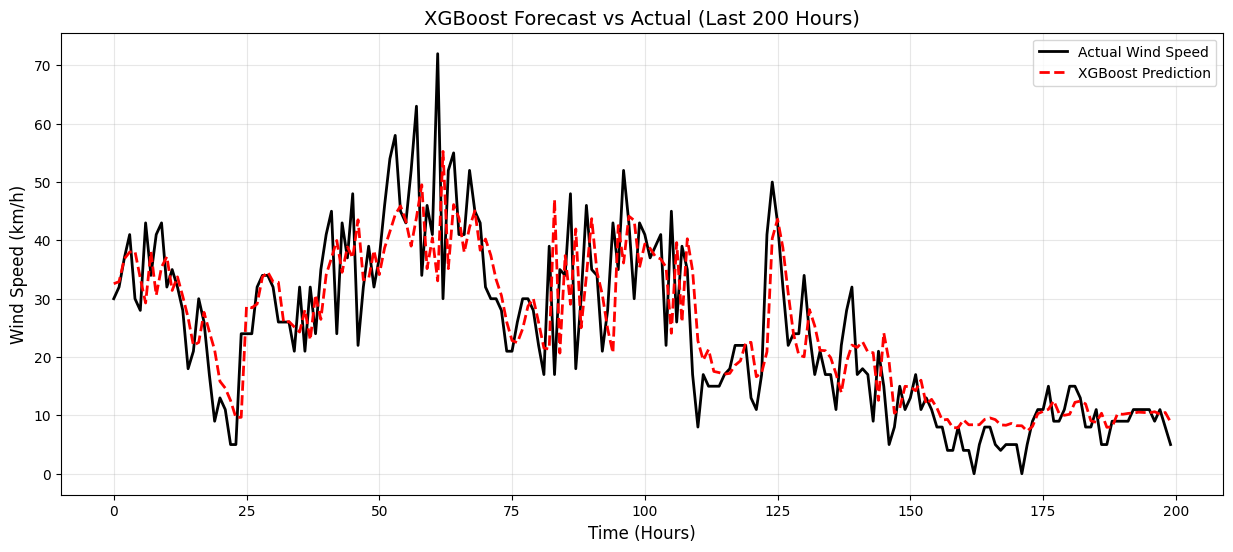

In [25]:
import matplotlib.pyplot as plt

# Plot last 200 hours to see details clearly
subset = 200 
actuals = test_df['target_wind_speed'].tail(subset).values
preds = test_df['pred_xgb'].tail(subset).values

plt.figure(figsize=(15, 6))
plt.plot(actuals, label='Actual Wind Speed', color='black', linewidth=2)
plt.plot(preds, label='XGBoost Prediction', color='red', linestyle='--', linewidth=2)

plt.title(f"XGBoost Forecast vs Actual (Last {subset} Hours)", fontsize=14)
plt.xlabel("Time (Hours)", fontsize=12)
plt.ylabel("Wind Speed (km/h)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

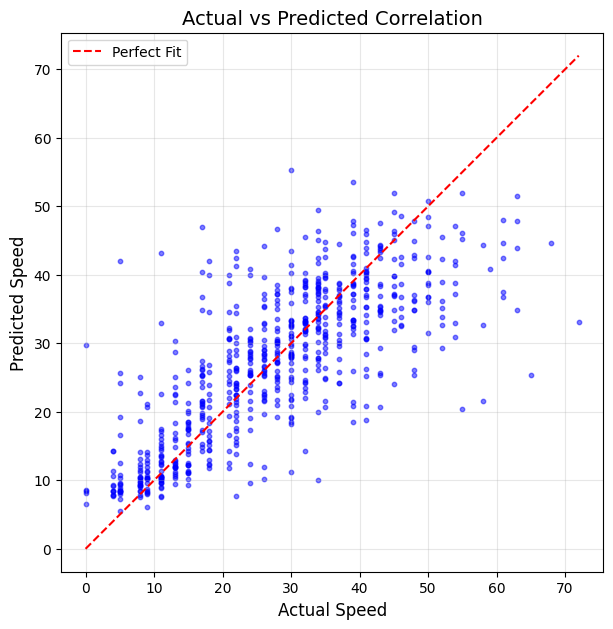

In [26]:
plt.figure(figsize=(7, 7))
plt.scatter(test_df['target_wind_speed'], test_df['pred_xgb'], alpha=0.5, s=10, color='blue')

# 1:1 Perfect Prediction Line
min_val = min(test_df['target_wind_speed'].min(), test_df['pred_xgb'].min())
max_val = max(test_df['target_wind_speed'].max(), test_df['pred_xgb'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Fit')

plt.title("Actual vs Predicted Correlation", fontsize=14)
plt.xlabel("Actual Speed", fontsize=12)
plt.ylabel("Predicted Speed", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

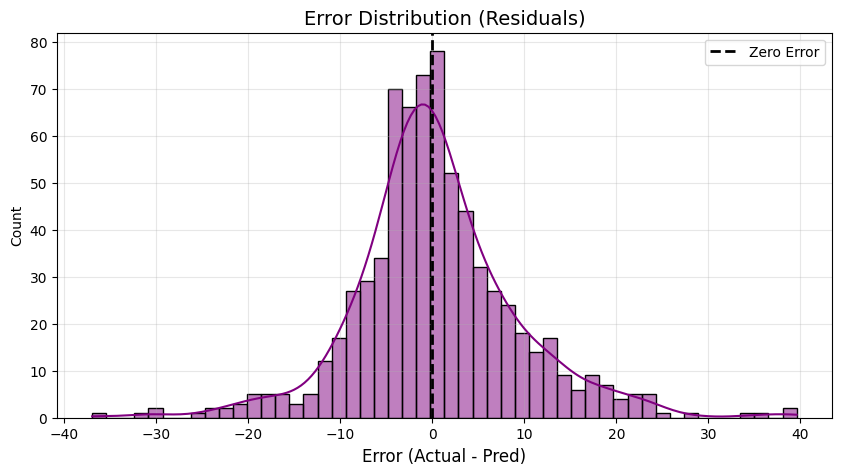

In [27]:
import seaborn as sns

residuals = test_df['target_wind_speed'] - test_df['pred_xgb']

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=50, color='purple')
plt.axvline(0, color='black', linestyle='--', linewidth=2, label='Zero Error')

plt.title("Error Distribution (Residuals)", fontsize=14)
plt.xlabel("Error (Actual - Pred)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

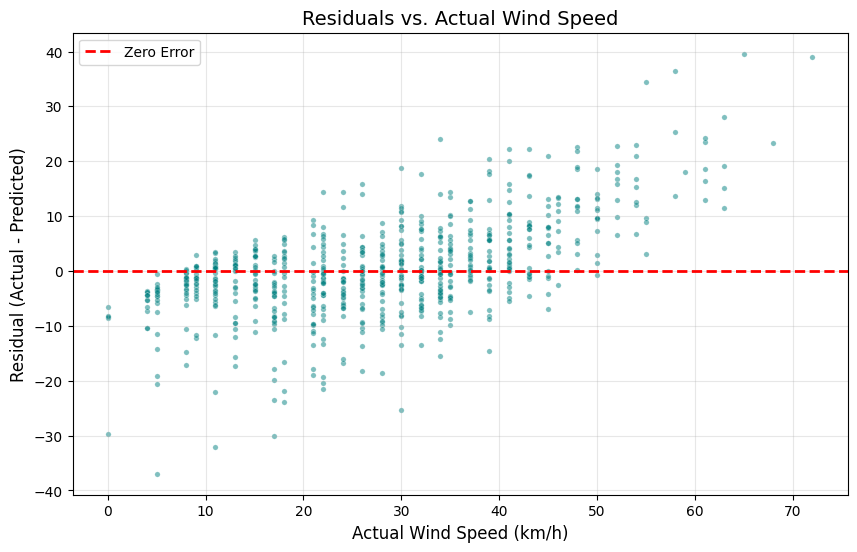

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Residuals
residuals = test_df['target_wind_speed'] - test_df['pred_xgb']

plt.figure(figsize=(10, 6))

# Scatter Plot
sns.scatterplot(x=test_df['target_wind_speed'], y=residuals, 
                color='teal', alpha=0.5, s=15)

# Zero Error Line (Ideal)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')

# Aesthetics
plt.title("Residuals vs. Actual Wind Speed", fontsize=14)
plt.xlabel("Actual Wind Speed (km/h)", fontsize=12)
plt.ylabel("Residual (Actual - Predicted)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()